# Goal : - Use the provided building energy data to develop a model that can predict a building's Energy Star score, and then interpret the results to find the variables that are most predictive of the score.
The first notebook covered steps 1-3 of machine learning work flow and in this notebook, we will cover 4-6. In this series, I focus more on the implementations rather than the details

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Imputing missing values and scaling values
from sklearn.preprocessing import Imputer, MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
# Read in data into dataframes 
train_features = pd.read_csv('/Users/macbook/Downloads/training_features.csv')
test_features = pd.read_csv('/Users/macbook/Downloads/testing_features.csv')
train_labels = pd.read_csv('/Users/macbook/Downloads/training_labels.csv')
test_labels = pd.read_csv('/Users/macbook/Downloads/testing_labels.csv')

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (6622, 64)
Testing Feature Size:   (2839, 64)
Training Labels Size:   (6622, 1)
Testing Labels Size:    (2839, 1)


In [3]:
train_features.head(12)

Order  Property Id  DOF Gross Floor Area  Year Built  \
0   13276      5849784               90300.0        1950   
1    7377      4398442               52000.0        1926   
2    9479      4665374              104700.0        1954   
3   14774      3393340              129333.0        1992   
4    3286      2704325              109896.0        1927   
5    1060      2430725              182655.0        1929   
6   10846      5737475               65400.0        1942   
7    4280      2670505              113150.0        1938   
8   12974      2964670              137700.0        1959   
9   13244      4414693               63693.0        1941   
10   3903      2669664               82644.0        1922   
11   8336      2809354               51317.0        1925   

    Number of Buildings - Self-reported  Occupancy  Site EUI (kBtu/ft²)  \
0                                     1        100                126.0   
1                                     1        100                 95.4   
2                                     1        100                 40.4   
3                                     1        100                157.1   
4                                     1        100                 62.3   
5                                     1         90                 52.9   
6                                     1        100                 66.8   
7                                     1        100                 78.4   
8                                     1        100                 63.0   
9                                     1        100                 97.8   
10                                    1        100                 55.4   
11                                    1        100                118.7   

    Weather Normalized Site Electricity Intensity (kWh/ft²)  \
0                                                 5.2         
1                                                 4.7         
2                                                 3.8         
3                                                16.9         
4                                                 3.5         
5                                                 9.7         
6                                                 3.0         
7                                                 5.7         
8                                                 3.4         
9                                                 4.3         
10                                                4.5         
11                                                3.6         

    Weather Normalized Site Natural Gas Intensity (therms/ft²)  \
0                                                 1.2            
1                                                 0.9            
2                                                 0.3            
3                                                 1.1            
4                                                 0.0            
5                                                 0.2            
6                                                 0.6            
7                                                 NaN            
8                                                 0.5            
9                                                 0.8            
10                                                0.0            
11                                                1.1            

    Water Intensity (All Water Sources) (gal/ft²)   Latitude  Longitude  \
0                                           99.41        NaN        NaN   
1                                             NaN  40.835496 -73.887745   
2                                             NaN  40.663206 -73.949469   
3                                             NaN  40.622968 -74.078742   
4                                           28.65  40.782421 -73.972622   
5                                            4.80  40.725136 -74.004438   
6                                          

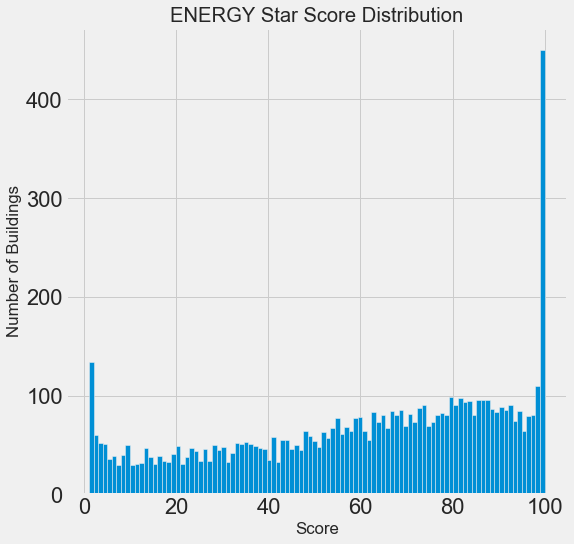

In [4]:
figsize(8, 8)

# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(train_labels['score'].dropna(), bins = 100);
plt.xlabel('Score'); plt.ylabel('Number of Buildings'); 
plt.title('ENERGY Star Score Distribution');


# Evaluating and Comparing Machine Learning Models
In this section we will build, train, and evalute several machine learning methods for our supervised regression task. The objective is to determine which model holds the most promise for further development (such as hyperparameter tuning).

In [5]:
# Create an imputer object with a median filling strategy
imputer = Imputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

/Users/macbook/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [6]:
print('Missing values in training features: ', np.sum(np.isnan(X)))
print('Missing values in testing features:  ', np.sum(np.isnan(X_test)))

Missing values in training features:  0
Missing values in testing features:   0


In [7]:
# Make sure all values are finite
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


In [8]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [9]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

# Models to Evaluate
We will compare five different machine learning models using the great Scikit-Learn library:
Linear Regression
Support Vector Machine Regression
Random Forest Regression
Gradient Boosting Regression
K-Nearest Neighbors Regression

In [10]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [11]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 13.4651


In [12]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE = 10.9337


In [13]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

/Users/macbook/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Regression Performance on the test set: MAE = 10.0073


In [14]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 10.0144


In [15]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 13.0131


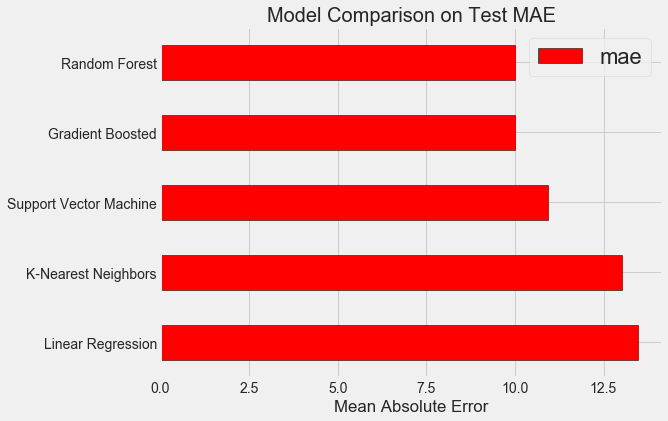

In [16]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lr_mae, svm_mae, random_forest_mae, 
                                         gradient_boosted_mae, knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

# Hyperparameter Tuning with Random Search and Cross Validation

In [17]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [18]:
# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

In [19]:
# Fit on the training data
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 15.7min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [20]:
# Get all of the cv results and sort by the test performance
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
12      21.213794      0.249668         0.026801        0.001276   
3       21.921301      0.453266         0.026114        0.000960   
9       13.534073      0.204988         0.019320        0.000975   
0        4.676031      0.042642         0.007001        0.000972   
7       10.866726      0.399921         0.020034        0.002760   
19      27.511085      0.679668         0.034852        0.001391   
10     106.770503      2.997115         0.106268        0.003652   
2       70.233919      2.577213         0.058420        0.005359   
16      35.581609      0.316817         0.054058        0.003290   
21       7.325313      0.220923         0.028200        0.000585   

   param_n_estimators param_min_samples_split param_min_samples_leaf  \
12                500                       6                      6   
3                 500                       6                      8   
9                 500                       4                      2   
0                 100                       2                      6   
7                 500                       4                      6   
19               1100                       6                      2   
10               1100                      10                      6   
2                 500                       4                      2   
16               1500                       4                      6   
21                500                       6                      4   

   param_max_features param_max_depth param_loss  \
12               None               5        lad   
3                None               5      huber   
9                auto               3      huber   
0                auto               5         ls   
7                auto               3         ls   
19               auto               3        lad   
10               None              10      huber   
2                auto              10      huber   
16               None               3         ls   
21               log2               5      huber   

                                               params  split0_test_score  \
12  {'n_estimators': 500, 'min_samples_split': 6, ...          -8.924621   
3   {'n_estimators': 500, 'min_samples_split': 6, ...          -8.872382   
9   {'n_estimators': 500, 'min_samples_split': 4, ...          -9.062297   
0   {'n_estimators': 100, 'min_samples_split': 2, ...          -9.100775   
7   {'n_estimators': 500, 'min_samples_split': 4, ...          -9.147703   
19  {'n_estimators': 1100, 'min_samples_split': 6,...          -9.350800   
10  {'n_estimators': 1100, 'min_samples_split': 10...          -9.274382   
2   {'n_estimators': 500, 'min_samples_split': 4, ...          -9.415934   
16  {'n_estimators': 1500, 'min_samples_split': 4,...          -9.248892   
21  {'n_estimators': 500, 'min_samples_split': 6, ...          -9.365194   

    split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
12          -8.775078          -9.325044          -9.037550        -9.015523   
3           -8.903982          -9.317120          -9.075047        -9.042086   
9           -9.042221          -9.439618          -9.153004        -9.174248   
0           -9.026372          -9.457063          -9.201235        -9.196321   
7           -9.199053          -9.698781          -9.358627        -9.350987   
19          -9.382812          -9.475236          -9.291753        -9.375148   
10          -9.242743          -9.530568          -9.475944        -9.380872   
2           -9.291198          -9.575363          -9.429866        -9.428068   
16          -9.316306          -9.798843          -9.427920        -9.447940   
21          -9.286988          -9.751767          -9.409179        -9.453243   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
12        0.201467                1           -6.934705           -6.837958   
3         0.1

In [21]:
random_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='lad', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=6,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [22]:
# Create a range of trees to evaluate
trees_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

model = GradientBoostingRegressor(loss = 'lad', max_depth = 5,
                                  min_samples_leaf = 6,
                                  min_samples_split = 6,
                                  max_features = None,
                                  random_state = 42)

# Grid Search Object using the trees range and the random forest model
grid_search = GridSearchCV(estimator = model, param_grid=trees_grid, cv = 4, 
                           scoring = 'neg_mean_absolute_error', verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [23]:
# Fit the grid search
grid_search.fit(X, y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.8min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='lad', max_depth=5,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=6,
                                                 min_samples_split=6,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
               

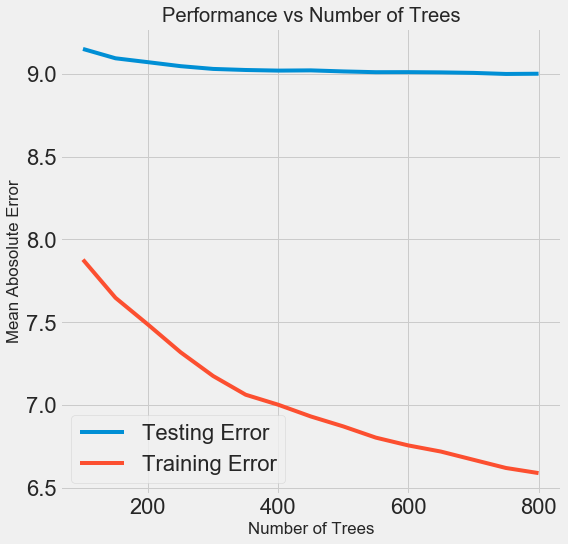

In [24]:
# Get the results into a dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Abosolute Error'); plt.legend();
plt.title('Performance vs Number of Trees');

In [25]:
results.sort_values('mean_test_score', ascending = False).head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
13      30.630622      0.338992         0.035849        0.000727   
14      32.112273      0.569476         0.032618        0.005702   
12      28.690898      0.402076         0.033797        0.000754   
11      27.033717      0.476275         0.031822        0.000604   
9       23.116518      0.118460         0.027587        0.001069   

   param_n_estimators                 params  split0_test_score  \
13                750  {'n_estimators': 750}          -8.901092   
14                800  {'n_estimators': 800}          -8.903857   
12                700  {'n_estimators': 700}          -8.904269   
11                650  {'n_estimators': 650}          -8.906208   
9                 550  {'n_estimators': 550}          -8.918502   

    split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
13          -8.751699          -9.298411          -9.049730        -9.000181   
14          -8.758299          -9.296941          -9.047485        -9.001594   
12          -8.755862          -9.312990          -9.053755        -9.006666   
11          -8.755401          -9.325190          -9.052215        -9.009699   
9           -8.756938          -9.325492          -9.042721        -9.010861   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
13        0.201836                1           -6.716494           -6.660453   
14        0.198793                2           -6.689643           -6.648109   
12        0.205811                3           -6.743886           -6.695770   
11        0.210186                4           -6.778068           -6.721452   
9         0.207970                5           -6.874737           -6.781878   

    split2_train_score  split3_train_score  mean_train_score  std_train_score  
13           -6.520818           -6.579989         -6.619438         0.074807  
14           -6.486269           -6.530287         -6.588577         0.083101  
12           -6.611240           -6.624919         -6.668953         0.053861  
11           -6.708191           -6.666758         -6.718617         0.039814  
9            -6.809121           -6.745712         -6.802862         0.047201

In [26]:
# Default model
default_model = GradientBoostingRegressor(random_state = 42)

# Select the best model
final_model = grid_search.best_estimator_

final_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='lad', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=6,
                          min_weight_fraction_leaf=0.0, n_estimators=750,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

# Evaluate Final Model on the Test Set

In [27]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

1.08 s ± 57.1 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [28]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

15.3 s ± 739 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [29]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_pred))

Default model performance on the test set: MAE = 10.0130.
Final model performance on the test set:   MAE = 9.0474.


/Users/macbook/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


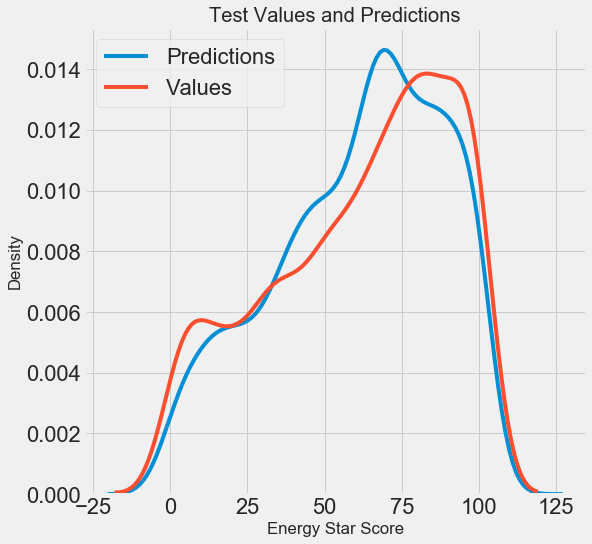

In [30]:
figsize(8, 8)

# Density plot of the final predictions and the test values
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.xlabel('Energy Star Score'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

The distribution looks to be nearly the same although the density of the predicted values is closer to the median of the test values rather than to the actual peak at 100. It appears the model might be less accurate at predicting the extreme values and instead predicts values closer to the median.
Another diagnostic plot is a histogram of the residuals. Ideally, we would hope that the residuals are normally distributed, meaning that the model is wrong the same amount in both directions (high and low).

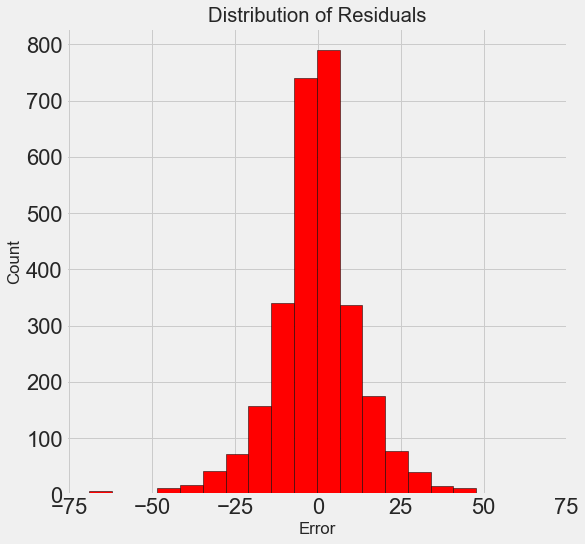

In [31]:
figsize = (6, 6)

# Calculate the residuals 
residuals = final_pred - y_test

# Plot the residuals in a histogram
plt.hist(residuals, color = 'red', bins = 20,
         edgecolor = 'black')
plt.xlabel('Error'); plt.ylabel('Count')
plt.title('Distribution of Residuals');

# Conclusions
In this notebook, we covered crucial concepts in the machine learning pipeline:
Imputing missing values
Evaluating and comparing several machine learning methods
Hyperparameter tuning a machine learning model using random search and cross validation
Evaluating the best model on the testing set
